In [1]:
#DATASETS:  https://www.kaggle.com/competitions/daasbstp2023/data

In [2]:
#Let's start by importing all packages needed.
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import seaborn as sns
from sklearn import preprocessing
import numpy as np
import time
from dateutil import parser
import pytz

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree, export_text


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

from scipy.stats import uniform, poisson

from sklearn.metrics import confusion_matrix, \
                            accuracy_score, \
                            precision_score, \
                            recall_score, \
                            f1_score, \
                            fbeta_score, \
                            mean_squared_error, \
                            mean_absolute_error, \
                            roc_auc_score, \
                            roc_curve, \
                            classification_report


# **Sample and Assess**

In [3]:
#Load the datasets.
df_en1 = pd.read_csv('daasbstp2023/energia_202109-202112.csv', na_filter=False, encoding = "latin")
df_en2 = pd.read_csv('daasbstp2023/energia_202201-202212.csv', na_filter=False, encoding = "latin")
df_me1 = pd.read_csv('daasbstp2023/meteo_202109-202112.csv', na_filter=False, encoding = "latin")
df_me2 = pd.read_csv('daasbstp2023/meteo_202201-202212.csv', na_filter=False, encoding = "latin")

In [4]:
#Append the datasets by type.
df_en = df_en1._append(df_en2,ignore_index=True)
df_me = df_me1._append(df_me2,ignore_index=True)

## Energy Consumption Dataset

This dataset provides information on energy consumption recorded at different timestamps. Each record includes the following columns:

- **Data (Date):** The timestamp associated with the record, indicating the date.
- **Hora (Hour):** The hour associated with the record.
- **Normal (kWh):** The amount of electrical energy consumed, in kilowatt-hours (kWh), from the electrical grid during a normal period in daily bi-hourly cycles (non-off-peak hours).
- **Horário Económico (kWh):** The amount of electrical energy consumed, in kilowatt-hours (kWh), from the electrical grid during an economic period in daily bi-hourly cycles (off-peak hours).
- **Autoconsumo (kWh):** The amount of electrical energy consumed, in kilowatt-hours (kWh), generated from solar panels (self-consumption).
- **Injeção na rede (kWh):** A qualitative feature indicating the level of energy injection into the grid on a scale of None, Low, Medium, High, and Very High.

This dataset is utilized in a competition and includes various features, with particular emphasis on the "Injeção na rede (kWh)" feature, which provides information about the qualitative scale of energy injection into the grid.

In [5]:
df_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     11016 non-null  object 
 1   Hora                     11016 non-null  int64  
 2   Normal (kWh)             11016 non-null  float64
 3   Horário Económico (kWh)  11016 non-null  float64
 4   Autoconsumo (kWh)        11016 non-null  float64
 5   Injeção na rede (kWh)    11016 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 516.5+ KB


In [6]:
df_en.iloc[901].to_frame().T

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
901,2021-11-05,13,0.0,0.0,0.274,Very High


In [7]:
df_en.isna().any()

Data                       False
Hora                       False
Normal (kWh)               False
Horário Económico (kWh)    False
Autoconsumo (kWh)          False
Injeção na rede (kWh)      False
dtype: bool

In [8]:
# Unique values for each column in the Energy dataset.
for column in df_en.columns:
    unique_values = df_en[column].unique()
    print(f"{column}, Number of Unique Values: {len(unique_values)}")

Data, Number of Unique Values: 459
Hora, Number of Unique Values: 24
Normal (kWh), Number of Unique Values: 1282
Horário Económico (kWh), Number of Unique Values: 851
Autoconsumo (kWh), Number of Unique Values: 752
Injeção na rede (kWh), Number of Unique Values: 5


## Weather Information Dataset

This dataset provides comprehensive information related to weather conditions at different timestamps. The columns in the dataset include:

- **dt (Timestamp):** The timestamp associated with the record.
- **dt_iso (ISO Date):** The date associated with the record, accurate to the second.
- **city_name:** The location for which weather data is recorded.
- **temp (Temperature):** The temperature in degrees Celsius.
- **feels_like (Feels Like):** The perceived temperature in degrees Celsius.
- **temp_min (Min Temperature):** The minimum felt temperature in degrees Celsius.
- **temp_max (Max Temperature):** The maximum felt temperature in degrees Celsius.
- **pressure:** Atmospheric pressure in atmospheres.
- **sea_level:** Atmospheric pressure at sea level in atmospheres.
- **grnd_level:** Atmospheric pressure at local altitude in atmospheres.
- **humidity:** Humidity level as a percentage.
- **wind_speed:** Wind speed in meters per second.
- **rain_1h (Rainfall):** Average precipitation value in the last hour.
- **clouds_all (Cloudiness):** Cloud coverage percentage.
- **weather_description:** Qualitative assessment of weather conditions.


In [9]:
df_me.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11688 entries, 0 to 11687
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   11688 non-null  int64  
 1   dt_iso               11688 non-null  object 
 2   city_name            11688 non-null  object 
 3   temp                 11688 non-null  float64
 4   feels_like           11688 non-null  float64
 5   temp_min             11688 non-null  float64
 6   temp_max             11688 non-null  float64
 7   pressure             11688 non-null  int64  
 8   sea_level            11688 non-null  object 
 9   grnd_level           11688 non-null  object 
 10  humidity             11688 non-null  int64  
 11  wind_speed           11688 non-null  float64
 12  rain_1h              11688 non-null  object 
 13  clouds_all           11688 non-null  int64  
 14  weather_description  11688 non-null  object 
dtypes: float64(5), int64(4), object(6)
m

In [10]:
df_me.iloc[801].to_frame().T

,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
801,1633338000,2021-10-04 09:00:00 +0000 UTC,local,14.03,13.84,13.34,14.54,1023,,,90,2.07,,69,broken clouds


In [11]:
df_me.isna().any()

dt                     False
dt_iso                 False
city_name              False
temp                   False
feels_like             False
temp_min               False
temp_max               False
pressure               False
sea_level              False
grnd_level             False
humidity               False
wind_speed             False
rain_1h                False
clouds_all             False
weather_description    False
dtype: bool

In [12]:
# Unique values for each column in the Energy dataset.
for column in df_me.columns:
    unique_values = df_me[column].unique()
    print(f"{column}, Number of Unique Values: {len(unique_values)}")

dt, Number of Unique Values: 11688
dt_iso, Number of Unique Values: 11688
city_name, Number of Unique Values: 1
temp, Number of Unique Values: 2423
feels_like, Number of Unique Values: 2702
temp_min, Number of Unique Values: 488
temp_max, Number of Unique Values: 550
pressure, Number of Unique Values: 41
sea_level, Number of Unique Values: 1
grnd_level, Number of Unique Values: 1
humidity, Number of Unique Values: 82
wind_speed, Number of Unique Values: 771
rain_1h, Number of Unique Values: 372
clouds_all, Number of Unique Values: 101
weather_description, Number of Unique Values: 8


# **Data Processing**

After Loading the data, we must now process it in order to be able to use it in our model. For this we will follow the following steps:
1. Remove unnecessary columns
2. Handle the Date column on both datasets and unify the format
3. Join the datasets
4. Handle the missing values or rows (dates that are not present in both datasets) if any
5. Handle the categorical values

In [13]:
# We can drop city_name, sea_level and grnd_level as they only have one unique value
df_me = df_me.drop(['city_name', 'sea_level', 'grnd_level'], axis=1)

In [14]:
# # Convert columns to categorical
# df_en["Injeção na rede (kWh)"] = df_en["Injeção na rede (kWh)"].astype("category")
# df_me["weather_description"] = df_me['weather_description'].astype("category")

# # For "Injeção na rede (kWh)" column in df_en
# print("Categories for 'Injeção na rede (kWh)' in df_en:")
# print(df_en["Injeção na rede (kWh)"].cat.categories)
# print("\n")

# # For "weather_description" column in df_me
# print("Categories for 'weather_description' in df_me:")
# print(df_me["weather_description"].cat.categories)
# print("\n")


In [15]:
# Convert columns to unified format
df_en['datetime'] = pd.to_datetime(df_en['Data'] + ' ' + df_en['Hora'].astype(str) + ':00:00', format='%Y-%m-%d %H:%M:%S')

# Drop the original 'Data' and 'Hora' columns if needed
df_en = df_en.drop(['Data', 'Hora'], axis=1)

# Print the updated DataFrame
df_en.iloc[901].to_frame().T

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),datetime
901,0.0,0.0,0.274,Very High,2021-11-05 13:00:00


In [16]:
df_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Normal (kWh)             11016 non-null  float64       
 1   Horário Económico (kWh)  11016 non-null  float64       
 2   Autoconsumo (kWh)        11016 non-null  float64       
 3   Injeção na rede (kWh)    11016 non-null  object        
 4   datetime                 11016 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 430.4+ KB


In [17]:
#fix datetime in df_me (loses the UTC tag)
df_me['dt_iso'] = pd.to_datetime(df_me['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC')
df_me['dt_iso'] = df_me['dt_iso'].dt.tz_localize(None)
df_me = df_me.rename(columns={"dt_iso": "datetime"})
df_me.iloc[801].to_frame().T

,dt,datetime,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description
801,1633338000,2021-10-04 09:00:00,14.03,13.84,13.34,14.54,1023,90,2.07,,69,broken clouds


In [18]:
# We can also drop the 'dt' column as it is redundant
df_me = df_me.drop(['dt'], axis=1)

In [19]:
# Order the dataframes by datetime so we can detect any time skips
df_en = df_en.sort_values(by=['datetime'])
df_me = df_me.sort_values(by=['datetime'])

In [20]:
time_diff_en = df_en['datetime'].diff()
time_diff_me = df_me['datetime'].diff()

# Print the irregular time intervals
irregularities_en = time_diff_en[time_diff_en != '0 days 01:00:00']
irregularities_me = time_diff_me[time_diff_me != '0 days 01:00:00']
print("Irregular time intervals in df_en:")
print(irregularities_en)
print("\n")
print("Irregular time intervals in df_me:")
print(irregularities_me)


Irregular time intervals in df_en:
0   NaT
Name: datetime, dtype: timedelta64[ns]


Irregular time intervals in df_me:
0   NaT
Name: datetime, dtype: timedelta64[ns]


In [21]:
outer_join_merged_df = pd.merge(df_en, df_me, on='datetime', how='outer')

In [22]:
outer_join_merged_df.isna().sum()

Normal (kWh)               672
Horário Económico (kWh)    672
Autoconsumo (kWh)          672
Injeção na rede (kWh)      672
datetime                     0
temp                         0
feels_like                   0
temp_min                     0
temp_max                     0
pressure                     0
humidity                     0
wind_speed                   0
rain_1h                      0
clouds_all                   0
weather_description          0
dtype: int64

Since the datetime data exhibited no irregularities, the additional entries present in the Weather dataset but not in the Energy dataset can be attributed to the Weather dataset containing data from days before or after the Energy dataset's first or last entry, respectively. A manual analysis of the dataset reveals that the Weather dataset includes entries starting from 2021-09-01, while the Energy dataset commences from 2021-09-29. Consequently, it is necessary to exclude entries from the Weather dataset that precede 2021-09-29, as they will not contribute to the modeling process. In order to achieve this we will do an Inner Join between the two datasets on the datetime column, and the resulting dataset will be the one we use going forward.

In [23]:
#at this point, if I do an inner join I am losing 5.7% of all datarows
merged_df = pd.merge(df_en, df_me, on='datetime', how='inner')

In [24]:
#Sava the clean dataset
merged_df.to_csv('merged.csv')

In [25]:
merged_df.rename(columns={'Injeção na rede (kWh)': 'Injection'}, inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Normal (kWh)             11016 non-null  float64       
 1   Horário Económico (kWh)  11016 non-null  float64       
 2   Autoconsumo (kWh)        11016 non-null  float64       
 3   Injection                11016 non-null  object        
 4   datetime                 11016 non-null  datetime64[ns]
 5   temp                     11016 non-null  float64       
 6   feels_like               11016 non-null  float64       
 7   temp_min                 11016 non-null  float64       
 8   temp_max                 11016 non-null  float64       
 9   pressure                 11016 non-null  int64         
 10  humidity                 11016 non-null  int64         
 11  wind_speed               11016 non-null  float64       
 12  rain_1h                  11016 n

In [26]:
merged_df.iloc[901].to_frame().T

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injection,datetime,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description
901,0.0,0.0,0.274,Very High,2021-11-05 13:00:00,15.75,14.92,13.12,17.88,1027,59,3.06,,1,sky is clear


In [27]:
# Convert 'rain_1h' column to float and replace empty strings with 0
merged_df['rain_1h'] = pd.to_numeric(merged_df['rain_1h'].replace('', '0'))

In [28]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Normal (kWh)             11016 non-null  float64       
 1   Horário Económico (kWh)  11016 non-null  float64       
 2   Autoconsumo (kWh)        11016 non-null  float64       
 3   Injection                11016 non-null  object        
 4   datetime                 11016 non-null  datetime64[ns]
 5   temp                     11016 non-null  float64       
 6   feels_like               11016 non-null  float64       
 7   temp_min                 11016 non-null  float64       
 8   temp_max                 11016 non-null  float64       
 9   pressure                 11016 non-null  int64         
 10  humidity                 11016 non-null  int64         
 11  wind_speed               11016 non-null  float64       
 12  rain_1h                  11016 n

In [29]:
weather_description_counts = merged_df['weather_description'].value_counts()
print(weather_description_counts)

weather_description
sky is clear            3010
overcast clouds         2430
light rain              1662
broken clouds           1413
scattered clouds        1148
few clouds               731
moderate rain            562
heavy intensity rain      60
Name: count, dtype: int64


In [30]:
# Perform One-Hot Encoding for 'weather_description'
merged_df = pd.get_dummies(merged_df, columns=['weather_description'], prefix='weather')


In [31]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Normal (kWh)                  11016 non-null  float64       
 1   Horário Económico (kWh)       11016 non-null  float64       
 2   Autoconsumo (kWh)             11016 non-null  float64       
 3   Injection                     11016 non-null  object        
 4   datetime                      11016 non-null  datetime64[ns]
 5   temp                          11016 non-null  float64       
 6   feels_like                    11016 non-null  float64       
 7   temp_min                      11016 non-null  float64       
 8   temp_max                      11016 non-null  float64       
 9   pressure                      11016 non-null  int64         
 10  humidity                      11016 non-null  int64         
 11  wind_speed                  

In [32]:
# sns.pairplot(merged_df[['Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)', 'temp', 'rain_1h', 'humidity']])
# plt.show()

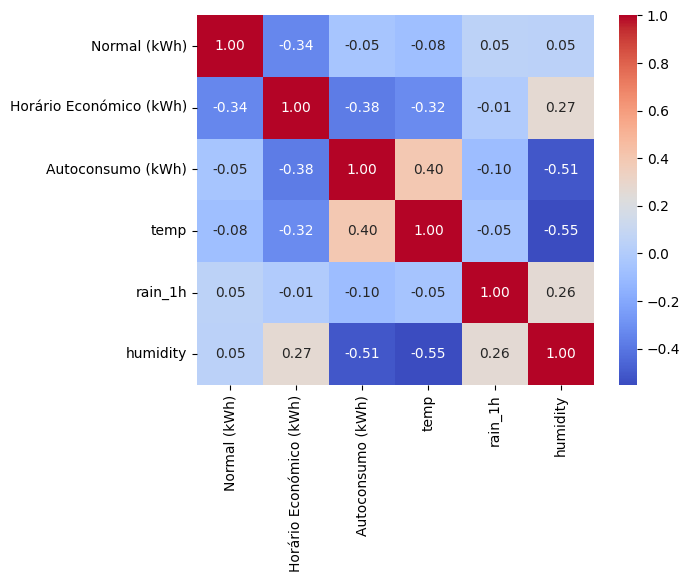

In [33]:
corr_matrix = merged_df[['Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)', 'temp', 'rain_1h', 'humidity']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

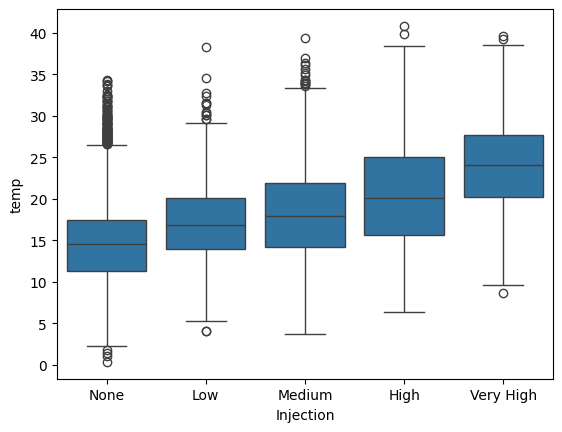

In [34]:
sns.boxplot(x='Injection', y='temp', data=merged_df)
plt.show()


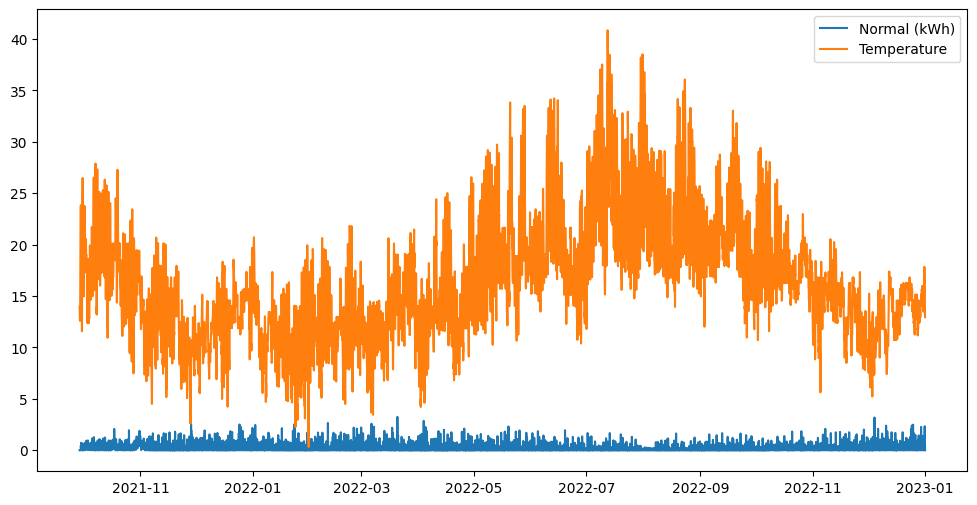

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['datetime'], merged_df['Normal (kWh)'], label='Normal (kWh)')
plt.plot(merged_df['datetime'], merged_df['temp'], label='Temperature')
plt.legend()
plt.show()

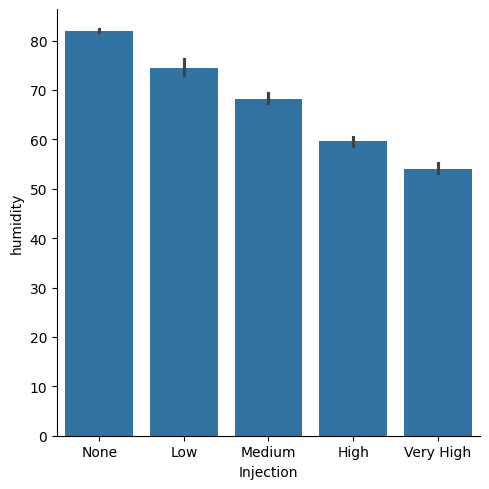

In [36]:
sns.catplot(x='Injection', y='humidity', kind='bar', data=merged_df)
plt.show()

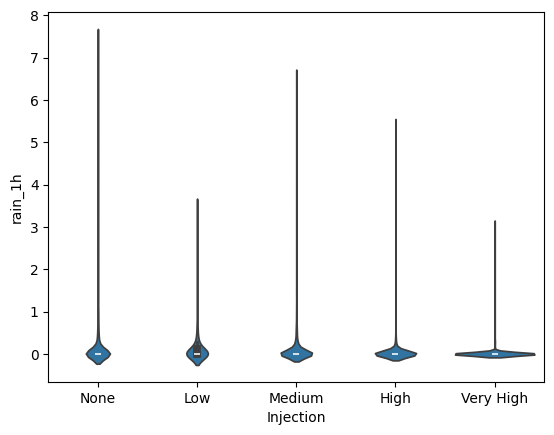

In [37]:
sns.violinplot(x='Injection', y='rain_1h', data=merged_df)
plt.show()

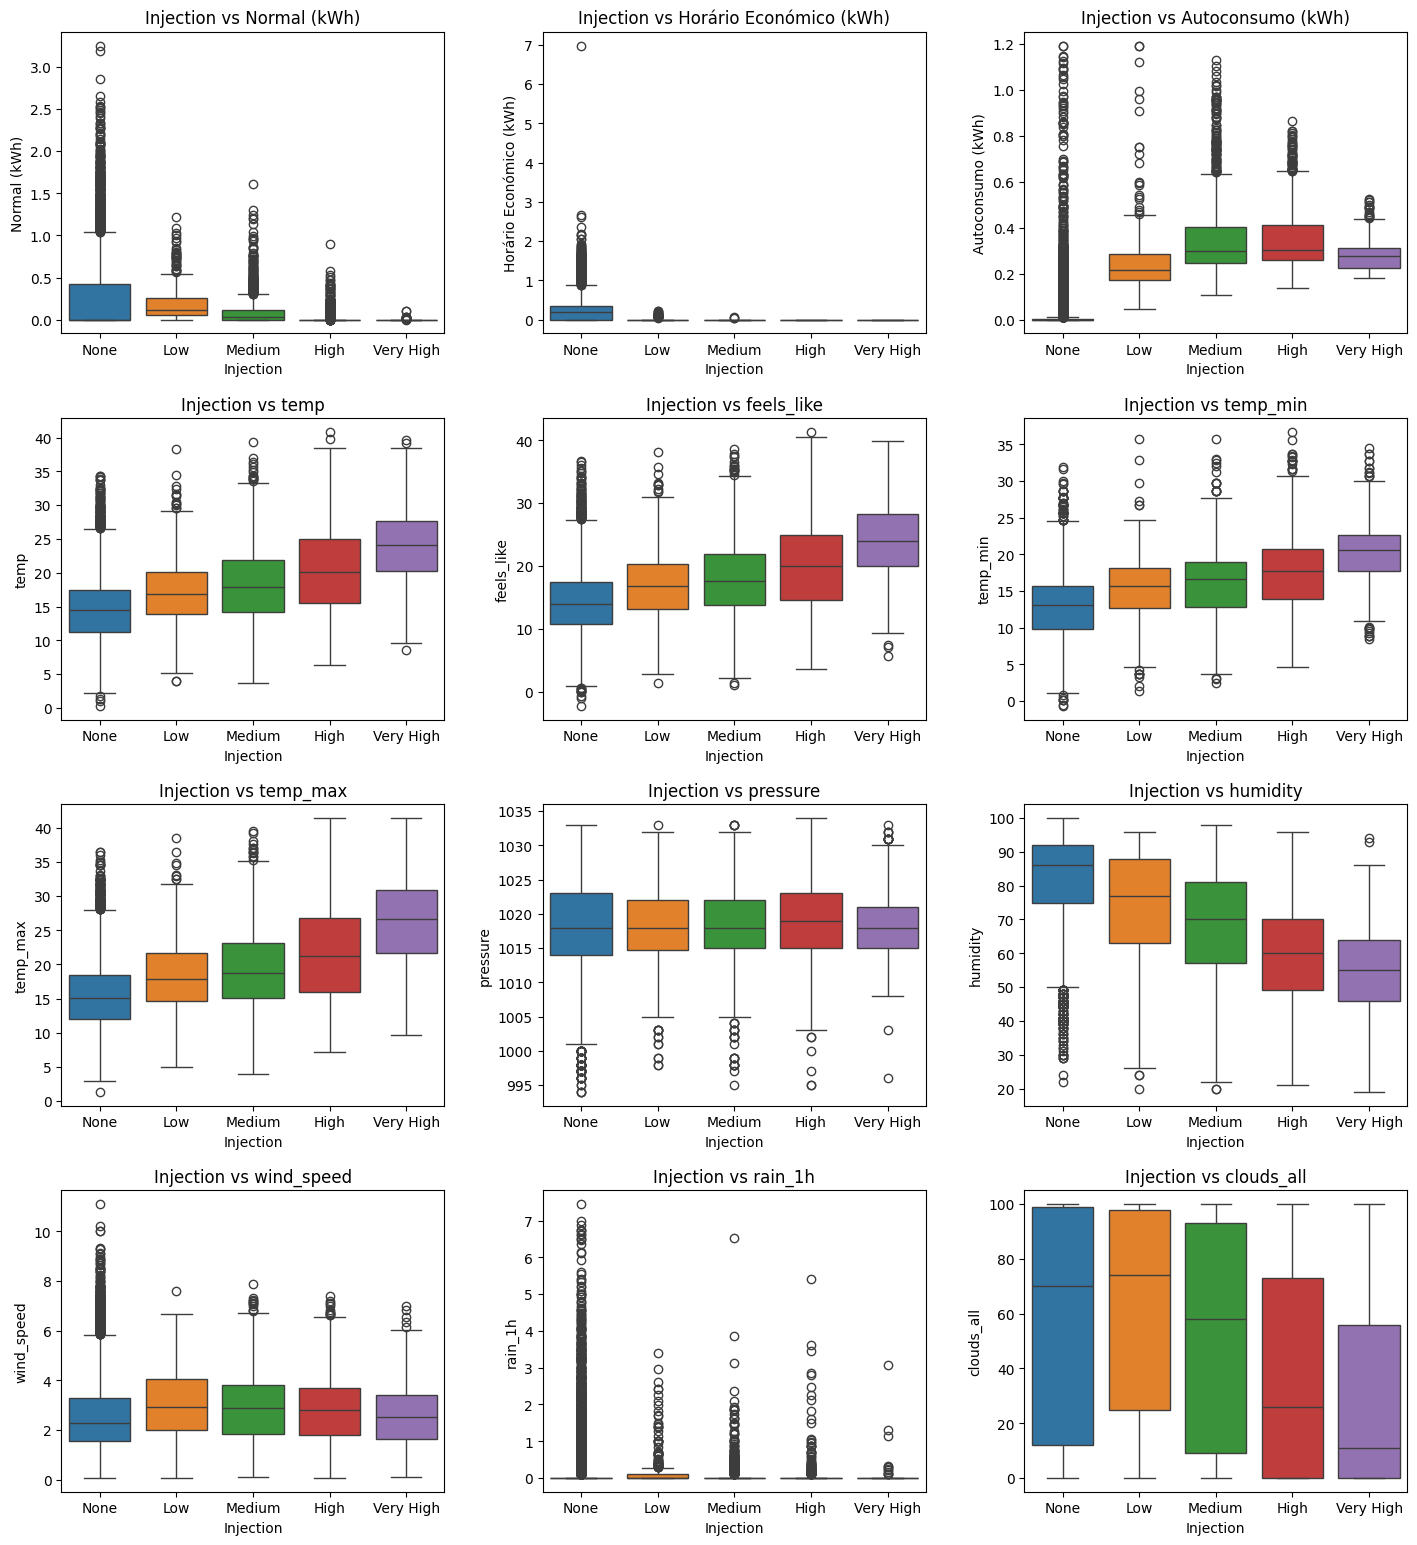

In [38]:
# Specify the columns you want to visualize
columns_to_visualize = ['Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)', 'temp', 'feels_like',
                         'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all']

# Set up subplots with multiple columns
num_columns = 3  # You can adjust the number of columns as per your preference
num_rows = -(-len(columns_to_visualize) // num_columns)  # Ceiling division to determine the number of rows

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, 4 * num_rows))
fig.tight_layout(pad=4.0)

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Create individual plots for each column
for i, column in enumerate(columns_to_visualize):
    ax = axes[i]
    sns.boxplot(x='Injection', y=column, data=merged_df, ax=ax, hue='Injection')
    ax.set_title(f'Injection vs {column}')
    ax.set_xlabel('Injection')
    ax.set_ylabel(column)

# Remove empty subplots if needed
for i in range(len(columns_to_visualize), len(axes)):
    fig.delaxes(axes[i])

plt.show()

The problem is a classification problem with ordinal labels. We have the following possible values for the target variable: None, Low, Medium, High, Very High. Here are some suitable models for ordinal classification:

1. **Ordinal Logistic Regression:**
   - **Type:** Supervised learning, ordinal classification.
   - **Strengths:** Designed specifically for ordinal outcomes, interpretable, and extends logistic regression to handle ordered categories.
   - **Considerations:** Assumes the proportional odds assumption.

2. **Random Forest Classifier for Ordinal Regression:**
   - **Type:** Supervised learning, classification.
   - **Strengths:** Handles non-linearity and interactions, robust to overfitting, and can handle ordinal targets by using the `OrdinalClassifier` from scikit-learn.
   - **Considerations:** Might not be as interpretable as ordinal logistic regression.

3. **Support Vector Machines (SVM) for Ordinal Classification:**
   - **Type:** Supervised learning, ordinal classification.
   - **Strengths:** Effective in high-dimensional spaces, versatile, and can be adapted for ordinal targets.
   - **Considerations:** Sensitive to the choice of kernel function and parameters.

4. **Ordinal Neural Networks:**
   - **Type:** Deep learning, ordinal classification.
   - **Strengths:** Can capture complex relationships, automatically learns feature representations, and can be adapted for ordinal outcomes.
   - **Considerations:** Requires more data, computationally intensive, and might be overkill for simpler problems.


# Preparing Test Dataset
---

In [39]:
test_en = pd.read_csv('daasbstp2023/energia_202301-202304.csv', na_filter=False, encoding = "latin")
test_me = pd.read_csv('daasbstp2023/meteo_202301-202304.csv', na_filter=False, encoding = "latin")

In [40]:
test_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     2256 non-null   object 
 1   Hora                     2256 non-null   int64  
 2   Normal (kWh)             2256 non-null   float64
 3   Horário Económico (kWh)  2256 non-null   float64
 4   Autoconsumo (kWh)        2256 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 88.2+ KB


In [41]:
test_me.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   1752 non-null   int64  
 1   dt_iso               1752 non-null   object 
 2   city_name            1752 non-null   object 
 3   temp                 1752 non-null   float64
 4   feels_like           1752 non-null   float64
 5   temp_min             1752 non-null   float64
 6   temp_max             1752 non-null   float64
 7   pressure             1752 non-null   int64  
 8   sea_level            1752 non-null   object 
 9   grnd_level           1752 non-null   object 
 10  humidity             1752 non-null   int64  
 11  wind_speed           1752 non-null   float64
 12  rain_1h              1752 non-null   object 
 13  clouds_all           1752 non-null   int64  
 14  weather_description  1752 non-null   object 
dtypes: float64(5), int64(4), object(6)
mem

In [42]:
test_me.isna().any()

dt                     False
dt_iso                 False
city_name              False
temp                   False
feels_like             False
temp_min               False
temp_max               False
pressure               False
sea_level              False
grnd_level             False
humidity               False
wind_speed             False
rain_1h                False
clouds_all             False
weather_description    False
dtype: bool

In [43]:
test_en.isna().any()

Data                       False
Hora                       False
Normal (kWh)               False
Horário Económico (kWh)    False
Autoconsumo (kWh)          False
dtype: bool

In [44]:
# Unique values for each column in the Energy dataset.
for column in test_en.columns:
    unique_values = test_en[column].unique()
    print(f"{column}, Number of Unique Values: {len(unique_values)}")

Data, Number of Unique Values: 94
Hora, Number of Unique Values: 24
Normal (kWh), Number of Unique Values: 709
Horário Económico (kWh), Number of Unique Values: 490
Autoconsumo (kWh), Number of Unique Values: 485


In [45]:
# Unique values for each column in the Meteorology dataset

for column in test_me.columns:
    unique_values = test_me[column].unique()
    print(f"{column}, Number of Unique Values: {len(unique_values)}")

dt, Number of Unique Values: 1752
dt_iso, Number of Unique Values: 1752
city_name, Number of Unique Values: 1
temp, Number of Unique Values: 889
feels_like, Number of Unique Values: 1007
temp_min, Number of Unique Values: 169
temp_max, Number of Unique Values: 174
pressure, Number of Unique Values: 31
sea_level, Number of Unique Values: 1
grnd_level, Number of Unique Values: 1
humidity, Number of Unique Values: 71
wind_speed, Number of Unique Values: 512
rain_1h, Number of Unique Values: 121
clouds_all, Number of Unique Values: 99
weather_description, Number of Unique Values: 8


In [46]:
test_me = test_me.drop(['city_name', 'sea_level', 'grnd_level'], axis=1)

In [47]:
# Convert columns to unified format
test_en['datetime'] = pd.to_datetime(test_en['Data'] + ' ' + test_en['Hora'].astype(str) + ':00:00', format='%Y-%m-%d %H:%M:%S')

# Drop the original 'Data' and 'Hora' columns if needed
test_en = test_en.drop(['Data', 'Hora'], axis=1)

# Print the updated DataFrame
test_en.iloc[901].to_frame().T

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),datetime
901,0.0,0.0,0.311,2023-02-07 13:00:00


In [48]:
# Fix datetime in test_me (loses the UTC tag)
test_me['dt_iso'] = pd.to_datetime(test_me['dt_iso'], format='%Y-%m-%d %H:%M:%S %z UTC')
test_me['dt_iso'] = test_me['dt_iso'].dt.tz_localize(None)
test_me = test_me.rename(columns={"dt_iso": "datetime"})
test_me.iloc[801].to_frame().T

,dt,datetime,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,rain_1h,clouds_all,weather_description
801,1675414800,2023-02-03 09:00:00,7.1,4.92,4.71,8.34,1033,81,3.16,,0,sky is clear


In [49]:
# We can also drop the 'dt' column as it is redundant
test_me = test_me.drop(['dt'], axis=1)

In [50]:
# Order the dataframes by datetime so we can detect any time skips
test_en = test_en.sort_values(by=['datetime'])
test_me = test_me.sort_values(by=['datetime'])

In [51]:
time_diff_en = df_en['datetime'].diff()
time_diff_me = df_me['datetime'].diff()

# Print the irregular time intervals
irregularities_en = time_diff_en[time_diff_en != '0 days 01:00:00']
irregularities_me = time_diff_me[time_diff_me != '0 days 01:00:00']
print("Irregular time intervals in df_en:")
print(irregularities_en)
print("\n")
print("Irregular time intervals in df_me:")
print(irregularities_me)

Irregular time intervals in df_en:
0   NaT
Name: datetime, dtype: timedelta64[ns]


Irregular time intervals in df_me:
0   NaT
Name: datetime, dtype: timedelta64[ns]


In [52]:
outer_join_test_df = pd.merge(test_en, test_me, on='datetime', how='outer')

In [53]:
outer_join_test_df.isna().sum()

Normal (kWh)                 0
Horário Económico (kWh)      0
Autoconsumo (kWh)            0
datetime                     0
temp                       504
feels_like                 504
temp_min                   504
temp_max                   504
pressure                   504
humidity                   504
wind_speed                 504
rain_1h                    504
clouds_all                 504
weather_description        504
dtype: int64

In [54]:
outer_join_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Normal (kWh)             2256 non-null   float64       
 1   Horário Económico (kWh)  2256 non-null   float64       
 2   Autoconsumo (kWh)        2256 non-null   float64       
 3   datetime                 2256 non-null   datetime64[ns]
 4   temp                     1752 non-null   float64       
 5   feels_like               1752 non-null   float64       
 6   temp_min                 1752 non-null   float64       
 7   temp_max                 1752 non-null   float64       
 8   pressure                 1752 non-null   float64       
 9   humidity                 1752 non-null   float64       
 10  wind_speed               1752 non-null   float64       
 11  rain_1h                  1752 non-null   object        
 12  clouds_all               1752 non-

In [55]:
test_merged = outer_join_test_df

test_merged['rain_1h'] = pd.to_numeric(test_merged['rain_1h'].replace('', '0'))

In [56]:
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Normal (kWh)             2256 non-null   float64       
 1   Horário Económico (kWh)  2256 non-null   float64       
 2   Autoconsumo (kWh)        2256 non-null   float64       
 3   datetime                 2256 non-null   datetime64[ns]
 4   temp                     1752 non-null   float64       
 5   feels_like               1752 non-null   float64       
 6   temp_min                 1752 non-null   float64       
 7   temp_max                 1752 non-null   float64       
 8   pressure                 1752 non-null   float64       
 9   humidity                 1752 non-null   float64       
 10  wind_speed               1752 non-null   float64       
 11  rain_1h                  1752 non-null   float64       
 12  clouds_all               1752 non-

In [57]:
# Perform One-Hot Encoding for 'weather_description'
test_merged = pd.get_dummies(test_merged, columns=['weather_description'], prefix='weather')

In [58]:
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Normal (kWh)                  2256 non-null   float64       
 1   Horário Económico (kWh)       2256 non-null   float64       
 2   Autoconsumo (kWh)             2256 non-null   float64       
 3   datetime                      2256 non-null   datetime64[ns]
 4   temp                          1752 non-null   float64       
 5   feels_like                    1752 non-null   float64       
 6   temp_min                      1752 non-null   float64       
 7   temp_max                      1752 non-null   float64       
 8   pressure                      1752 non-null   float64       
 9   humidity                      1752 non-null   float64       
 10  wind_speed                    1752 non-null   float64       
 11  rain_1h                       

In [59]:
# Assuming merged_df['datetime'] and test_merged['datetime'] are in datetime format
test_merged_filled = test_merged.copy()

# Iterate over rows in test_merged
for index, row in test_merged.iterrows():
    if pd.isna(row['temp']):
        # Find the corresponding row in merged_df for the same hour on previous days
        matching_rows = merged_df[
            (merged_df['datetime'].dt.hour == row['datetime'].hour) &
            (merged_df['datetime'] < row['datetime'])
        ]

        # Check if matching_rows is not empty
        if not matching_rows.empty:
            # Use the values from the last available row
            matching_row = matching_rows.iloc[-1]

            # Update the missing values in test_merged with values from merged_df
            test_merged_filled.loc[index, ['temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all']] = matching_row[['temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all']]

# Now, test_merged_filled should have missing values filled with corresponding values from merged_df
test_merged_filled.info()

test_merged_filled.iloc[2200].to_frame().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Normal (kWh)                  2256 non-null   float64       
 1   Horário Económico (kWh)       2256 non-null   float64       
 2   Autoconsumo (kWh)             2256 non-null   float64       
 3   datetime                      2256 non-null   datetime64[ns]
 4   temp                          2256 non-null   float64       
 5   feels_like                    2256 non-null   float64       
 6   temp_min                      2256 non-null   float64       
 7   temp_max                      2256 non-null   float64       
 8   pressure                      2256 non-null   float64       
 9   humidity                      2256 non-null   float64       
 10  wind_speed                    2256 non-null   float64       
 11  rain_1h                       

,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),datetime,temp,feels_like,temp_min,temp_max,pressure,humidity,...,rain_1h,clouds_all,weather_broken clouds,weather_few clouds,weather_heavy intensity rain,weather_light rain,weather_moderate rain,weather_overcast clouds,weather_scattered clouds,weather_sky is clear
2200,0.015,0.0,0.465,2023-04-02 16:00:00,16.79,16.38,15.9,16.82,1017.0,71.0,...,0.43,92.0,False,False,False,False,False,False,False,False


In [84]:
# Count the number of each unique value in merged_df['Injection']
injection_counts = merged_df['Injection'].value_counts()
print(injection_counts)

Injection
None         7777
High         1103
Medium       1098
Very High     606
Low           432
Name: count, dtype: int64


# Logistic Regression
---

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score

In [61]:
# Prepare training data
X_train = merged_df[['Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)', 'temp', 'feels_like',
                     'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all',
                     'weather_broken clouds', 'weather_few clouds', 'weather_heavy intensity rain',
                     'weather_light rain', 'weather_moderate rain', 'weather_overcast clouds',
                     'weather_scattered clouds', 'weather_sky is clear']]
y_train = merged_df['Injection']


In [62]:
# Train logistic regression model
logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
logreg.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [63]:
# Prepare test data
X_test = test_merged_filled[['Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)', 'temp', 'feels_like',
                   'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all',
                   'weather_broken clouds', 'weather_few clouds', 'weather_heavy intensity rain',
                   'weather_light rain', 'weather_moderate rain', 'weather_overcast clouds',
                   'weather_scattered clouds', 'weather_sky is clear']].copy()

# # Handle missing values by filling with mean
# X_test.fillna(X_test.mean(), inplace=True)


In [64]:
# Make predictions on the test data
predictions = logreg.predict(X_test)

In [65]:
# Save predictions to a CSV file
result_df = pd.DataFrame({'RowId': range(1, len(predictions) + 1), 'Result': predictions})
result_df.to_csv('logreg_predictions.csv', index=False)

In [66]:
# Display the classification report and accuracy score on the training data
y_train_pred = logreg.predict(X_train)
print("Classification Report on Training Data:\n", classification_report(y_train, y_train_pred))
print("Accuracy Score on Training Data:", accuracy_score(y_train, y_train_pred))

Classification Report on Training Data:
               precision    recall  f1-score   support

        High       0.51      0.62      0.56      1103
         Low       0.00      0.00      0.00       432
      Medium       0.51      0.53      0.52      1098
        None       0.96      0.98      0.97      7777
   Very High       0.55      0.48      0.51       606

    accuracy                           0.84     11016
   macro avg       0.51      0.52      0.51     11016
weighted avg       0.81      0.84      0.82     11016

Accuracy Score on Training Data: 0.8359658678286129


# Support Vector Machine (SVM)
---

In [67]:
from sklearn.svm import SVC

In [68]:
# Train SVM model
svm_model = make_pipeline(StandardScaler(), SVC())
svm_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [69]:
# Make predictions on the test data
svm_predictions = svm_model.predict(X_test)

In [70]:
# Save SVM predictions to a CSV file
svm_result_df = pd.DataFrame({'RowId': range(1, len(svm_predictions) + 1), 'Result': svm_predictions})
svm_result_df.to_csv('svm_predictions.csv', index=False)

In [71]:
# Display the classification report and accuracy score on the training data
y_train_svm_pred = svm_model.predict(X_train)
print("Classification Report on Training Data:\n", classification_report(y_train, y_train_svm_pred))
print("Accuracy Score on Training Data:", accuracy_score(y_train, y_train_svm_pred))

Classification Report on Training Data:
               precision    recall  f1-score   support

        High       0.52      0.63      0.57      1103
         Low       0.43      0.01      0.01       432
      Medium       0.52      0.59      0.55      1098
        None       0.97      0.98      0.97      7777
   Very High       0.59      0.49      0.54       606

    accuracy                           0.84     11016
   macro avg       0.60      0.54      0.53     11016
weighted avg       0.83      0.84      0.83     11016

Accuracy Score on Training Data: 0.8434095860566448


# Random Forest
---

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score

In [73]:
# Create a Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=422)

In [74]:
# Train the model
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=422)

In [75]:
# Make predictions on the test data
predictions = random_forest.predict(X_test)

In [76]:
# Save predictions to a CSV file
result_df = pd.DataFrame({'RowId': range(1, len(predictions) + 1), 'Result': predictions})
result_df.to_csv('random_forest_predictions.csv', index=False)

In [77]:
# Display the classification report and accuracy score on the training data
y_train_pred = random_forest.predict(X_train)
print("Classification Report on Training Data:\n", classification_report(y_train, y_train_pred))
print("Accuracy Score on Training Data:", accuracy_score(y_train, y_train_pred))

Classification Report on Training Data:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00      1103
         Low       1.00      1.00      1.00       432
      Medium       1.00      1.00      1.00      1098
        None       1.00      1.00      1.00      7777
   Very High       1.00      1.00      1.00       606

    accuracy                           1.00     11016
   macro avg       1.00      1.00      1.00     11016
weighted avg       1.00      1.00      1.00     11016

Accuracy Score on Training Data: 1.0


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END class_weight=balanced, max_depth=None, min_samples

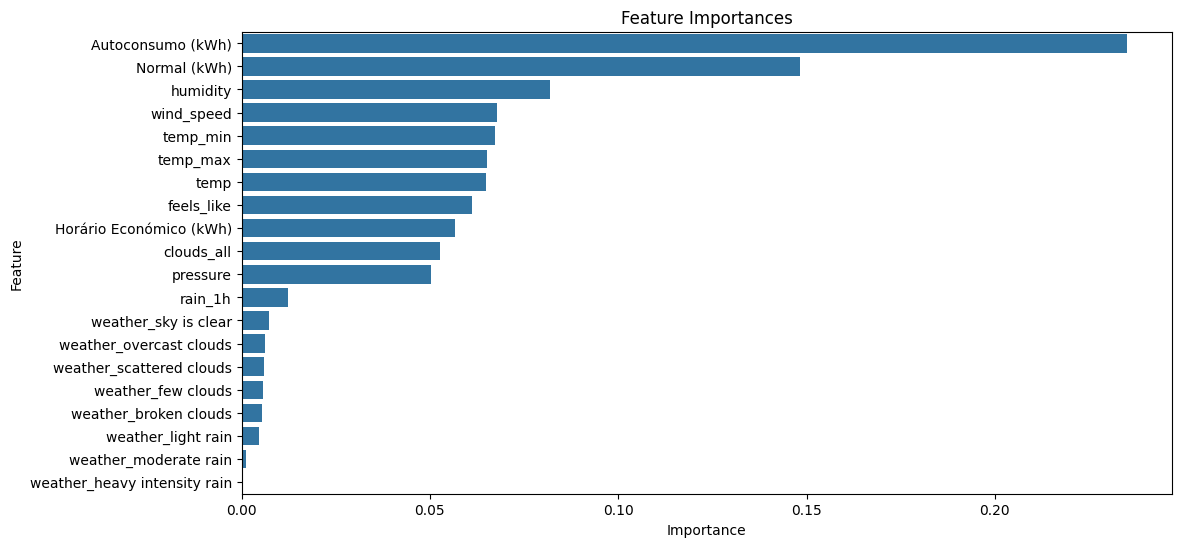

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the Random Forest Classifier
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Perform grid search for hyperparameter tuning on the training set
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Display the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# Get the best model from grid search
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the testing data
y_test_pred = best_rf_model.predict(X_test)
print("Classification Report on Testing Data:\n", classification_report(y_test, y_test_pred))
print("Accuracy Score on Testing Data:", accuracy_score(y_test, y_test_pred))

# Extract and visualize feature importances
feature_importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:\n", feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()

# Make predictions on the test_merged dataset
X_test_merged = test_merged[['Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)', 'temp', 'feels_like',
                      'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all',
                      'weather_broken clouds', 'weather_few clouds', 'weather_heavy intensity rain',
                      'weather_light rain', 'weather_moderate rain', 'weather_overcast clouds',
                      'weather_scattered clouds', 'weather_sky is clear']].copy()

# Handle missing values by filling with mean
X_test_merged.fillna(X_test_merged.mean(), inplace=True)

# Make predictions on the test_merged data
predictions_test = best_rf_model.predict(X_test_merged)

# Map predictions to the correct labels
label_mapping = {0: 'High', 1: 'Low', 2: 'Medium', 3: 'None', 4: 'Very High'}
predictions_test_labels = [label_mapping[prediction] for prediction in predictions_test]

# Save predictions to a CSV file
result_df_test = pd.DataFrame({'RowId': range(1, len(predictions_test) + 1), 'Result': predictions_test_labels})
result_df_test.to_csv('rf_predictions_test.csv', index=False)
